# Deep Learning Template

In [93]:
#imports 
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



<h4 style="color:yellow;">Set Parameters</h4>

In [94]:
learning_rate = 0.001 
batch_size = 5
epochs = 200

# Neil - 1-5 ReLU
# Adrian - 1-5 PReLU
# Rosette - 6-10 ReLU
# Jason - 6-10 PReLU
# Pau - Identity

# uncomment the activation function you want to use
activation = nn.ReLU() # all negative values are turned to 0 (best if preprocessing include transformation to positive x values)

# print("activation == nn.ReLU():", activation == nn.ReLU())
# print("isinstance(activation, nn.ReLU):", isinstance(activation, nn.ReLU))

# activation = nn.PReLU()
#activation = nn.Identity()

activation == nn.ReLU(): False
isinstance(activation, nn.ReLU): True


Load dataset

In [95]:
x_train = pd.read_csv("./current_iteration_files/x_train.csv", index_col=0)
y_train = pd.read_csv("./current_iteration_files/y_train.csv", index_col=0)
x_test = pd.read_csv("./current_iteration_files/x_test.csv", index_col=0)
y_test = pd.read_csv("./current_iteration_files/y_test.csv", index_col=0)

# if activation == nn.ReLU():
if isinstance(activation, nn.ReLU):

    min_max_scaler = MinMaxScaler()
    y_train_norm = min_max_scaler.fit_transform(y_train)
    y_test_norm = min_max_scaler.transform(y_test)

    x_train = torch.Tensor(x_train.values)
    y_train = torch.Tensor(y_train_norm)
    x_test = torch.Tensor(x_test.values)
    y_test = torch.Tensor(y_test_norm)

else:
    x_train = torch.Tensor(x_train.values)
    y_train = torch.Tensor(y_train.values)
    x_test = torch.Tensor(x_test.values)
    y_test = torch.Tensor(y_test.values)


In [96]:
# setting device to use (in case device you're using has GPU or MPS, use this for faster training)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using {} device".format(device))



Using cpu device


Building the neural network architecture

<h4 style="color:yellow;">Edit "multiple layers" to experiment with different architectures</h4>

In [97]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.activation = activation
        
        # feel free to add more or reduce the no of layers
        # make sure starting and ending dimensions are self.in_dim and self.out_dim
        self.multiple_layers = nn.Sequential(
            nn.Linear(self.in_dim, 24),
            self.activation,

            nn.Linear(24, 12),
            self.activation,

            nn.Linear(12, 6),
            self.activation,

            nn.Linear(6, 3),
            self.activation,

            nn.Linear(3, 2),
            self.activation,

            nn.Linear(2, self.out_dim),
            self.activation,
        )
        
    
    def forward(self, x):
        
        y = self.multiple_layers(x)
    
        return y

In [98]:
in_dim = x_train.shape[1]
out_dim = y_train.shape[1]
print("in_dim:", in_dim, "\nout_dim:", out_dim)

in_dim: 47 
out_dim: 1


In [100]:
model = NeuralNetwork(in_dim, out_dim)

# Test structure of model
predictions = model.forward(x_train)

print(predictions.shape)
predictions

torch.Size([15441, 1])


tensor([[0.4873],
        [0.4966],
        [0.4949],
        ...,
        [0.4944],
        [0.4984],
        [0.4865]], grad_fn=<ReluBackward0>)

Other parameters you can change(?)

In [101]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #optimization function
loss_fn = nn.MSELoss() # loss function

In [102]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [103]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [104]:

custom_dataset = MyCustomDataset(x=x_train, y=y_train)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))



Epoch: 0


100%|██████████| 3089/3089 [00:14<00:00, 209.86it/s, loss=0.000324]


Ave Loss: 0.003247407212879523
Epoch: 1


100%|██████████| 3089/3089 [00:15<00:00, 204.56it/s, loss=2.13e-5] 


Ave Loss: 0.0006566738223768893
Epoch: 2


100%|██████████| 3089/3089 [00:15<00:00, 203.07it/s, loss=9.53e-6] 


Ave Loss: 0.0005323413086248994
Epoch: 3


100%|██████████| 3089/3089 [00:15<00:00, 200.20it/s, loss=0.000393]


Ave Loss: 0.000506841954018556
Epoch: 4


100%|██████████| 3089/3089 [00:15<00:00, 199.09it/s, loss=4.6e-5]  


Ave Loss: 0.000437051784403626
Epoch: 5


100%|██████████| 3089/3089 [00:15<00:00, 194.07it/s, loss=6.71e-5] 


Ave Loss: 0.0004087891198823586
Epoch: 6


100%|██████████| 3089/3089 [00:15<00:00, 198.66it/s, loss=0.000133]


Ave Loss: 0.0004379342645252306
Epoch: 7


100%|██████████| 3089/3089 [00:15<00:00, 198.07it/s, loss=0.000158]


Ave Loss: 0.0003875278943899009
Epoch: 8


100%|██████████| 3089/3089 [00:15<00:00, 196.94it/s, loss=0.000123]


Ave Loss: 0.00038655734855400694
Epoch: 9


100%|██████████| 3089/3089 [00:15<00:00, 202.97it/s, loss=9.36e-5] 


Ave Loss: 0.00039777706263740154
Epoch: 10


100%|██████████| 3089/3089 [00:14<00:00, 209.57it/s, loss=2.7e-5]  


Ave Loss: 0.0003852627419224102
Epoch: 11


100%|██████████| 3089/3089 [00:14<00:00, 209.37it/s, loss=4.79e-5] 


Ave Loss: 0.00038287711904077425
Epoch: 12


100%|██████████| 3089/3089 [00:14<00:00, 207.14it/s, loss=0.000101]


Ave Loss: 0.0003755186698884399
Epoch: 13


100%|██████████| 3089/3089 [00:14<00:00, 208.86it/s, loss=8.51e-5] 


Ave Loss: 0.00037183768439395126
Epoch: 14


100%|██████████| 3089/3089 [00:14<00:00, 209.81it/s, loss=1.03e-5] 


Ave Loss: 0.00034548387161935205
Epoch: 15


100%|██████████| 3089/3089 [00:14<00:00, 210.25it/s, loss=7.49e-5] 


Ave Loss: 0.00033544474812764047
Epoch: 16


100%|██████████| 3089/3089 [00:15<00:00, 203.87it/s, loss=0.000125]


Ave Loss: 0.0003339746120482877
Epoch: 17


100%|██████████| 3089/3089 [00:15<00:00, 201.04it/s, loss=0.000175]


Ave Loss: 0.0003264862931126485
Epoch: 18


100%|██████████| 3089/3089 [00:15<00:00, 199.93it/s, loss=4.99e-6] 


Ave Loss: 0.00032455368515458855
Epoch: 19


100%|██████████| 3089/3089 [00:14<00:00, 207.78it/s, loss=3.71e-5] 


Ave Loss: 0.00031763021836900474
Epoch: 20


100%|██████████| 3089/3089 [00:14<00:00, 209.12it/s, loss=5.82e-6] 


Ave Loss: 0.0003158782831556884
Epoch: 21


100%|██████████| 3089/3089 [00:14<00:00, 209.27it/s, loss=6.43e-5] 


Ave Loss: 0.0003096426258007203
Epoch: 22


100%|██████████| 3089/3089 [00:14<00:00, 208.06it/s, loss=0.000155]


Ave Loss: 0.0003066878555743786
Epoch: 23


100%|██████████| 3089/3089 [00:14<00:00, 207.40it/s, loss=5.37e-5] 


Ave Loss: 0.0003016615810123474
Epoch: 24


100%|██████████| 3089/3089 [00:14<00:00, 207.65it/s, loss=2.88e-5] 


Ave Loss: 0.00029739863391181176
Epoch: 25


100%|██████████| 3089/3089 [00:14<00:00, 208.27it/s, loss=0.000134]


Ave Loss: 0.00029731305552000966
Epoch: 26


100%|██████████| 3089/3089 [00:14<00:00, 207.06it/s, loss=5.16e-6] 


Ave Loss: 0.0002968947690932341
Epoch: 27


100%|██████████| 3089/3089 [00:15<00:00, 204.58it/s, loss=2.47e-5] 


Ave Loss: 0.000291214208603912
Epoch: 28


100%|██████████| 3089/3089 [00:17<00:00, 174.74it/s, loss=0.000167]


Ave Loss: 0.00029048576465874647
Epoch: 29


100%|██████████| 3089/3089 [00:17<00:00, 176.33it/s, loss=1.63e-5] 


Ave Loss: 0.00029310899764170215
Epoch: 30


100%|██████████| 3089/3089 [00:17<00:00, 172.26it/s, loss=0.000137]


Ave Loss: 0.0002853889504878333
Epoch: 31


100%|██████████| 3089/3089 [00:16<00:00, 190.96it/s, loss=1.14e-5] 


Ave Loss: 0.00028615218523327785
Epoch: 32


100%|██████████| 3089/3089 [00:16<00:00, 188.74it/s, loss=1.03e-5] 


Ave Loss: 0.0002801920192323056
Epoch: 33


100%|██████████| 3089/3089 [00:17<00:00, 180.48it/s, loss=2.7e-6]  


Ave Loss: 0.00027820658740667297
Epoch: 34


100%|██████████| 3089/3089 [00:18<00:00, 170.88it/s, loss=6.27e-6] 


Ave Loss: 0.0002803071383231603
Epoch: 35


100%|██████████| 3089/3089 [00:20<00:00, 153.01it/s, loss=8.12e-5] 


Ave Loss: 0.00027373661887293116
Epoch: 36


100%|██████████| 3089/3089 [00:17<00:00, 179.06it/s, loss=0.000122]


Ave Loss: 0.0002700743238822917
Epoch: 37


100%|██████████| 3089/3089 [00:14<00:00, 213.73it/s, loss=4.72e-5] 


Ave Loss: 0.000270874055132699
Epoch: 38


100%|██████████| 3089/3089 [00:14<00:00, 207.80it/s, loss=3.86e-6] 


Ave Loss: 0.0002729077423082221
Epoch: 39


100%|██████████| 3089/3089 [00:15<00:00, 202.13it/s, loss=2.06e-5] 


Ave Loss: 0.0002724915181665714
Epoch: 40


100%|██████████| 3089/3089 [00:15<00:00, 203.44it/s, loss=0.000187]


Ave Loss: 0.00029587877204493787
Epoch: 41


100%|██████████| 3089/3089 [00:16<00:00, 184.85it/s, loss=5.23e-5] 


Ave Loss: 0.00029342543409150026
Epoch: 42


100%|██████████| 3089/3089 [00:15<00:00, 194.00it/s, loss=0.000186]


Ave Loss: 0.0002930399786054262
Epoch: 43


100%|██████████| 3089/3089 [00:13<00:00, 228.68it/s, loss=3.29e-6] 


Ave Loss: 0.00029276453476200263
Epoch: 44


100%|██████████| 3089/3089 [00:13<00:00, 236.11it/s, loss=0.000103]


Ave Loss: 0.00028657346316809793
Epoch: 45


100%|██████████| 3089/3089 [00:13<00:00, 229.14it/s, loss=1.47e-5] 


Ave Loss: 0.00027929649942223556
Epoch: 46


100%|██████████| 3089/3089 [00:13<00:00, 236.98it/s, loss=1.37e-6] 


Ave Loss: 0.000279863868048625
Epoch: 47


100%|██████████| 3089/3089 [00:13<00:00, 235.18it/s, loss=0.000254]


Ave Loss: 0.00027407310880302307
Epoch: 48


100%|██████████| 3089/3089 [00:12<00:00, 240.74it/s, loss=1.45e-9] 


Ave Loss: 0.00027209611337229483
Epoch: 49


100%|██████████| 3089/3089 [00:12<00:00, 241.52it/s, loss=0.000838]


Ave Loss: 0.0002680929593408142
Epoch: 50


100%|██████████| 3089/3089 [00:13<00:00, 223.24it/s, loss=5.62e-6] 


Ave Loss: 0.00027100010277718013
Epoch: 51


100%|██████████| 3089/3089 [00:13<00:00, 223.57it/s, loss=4.41e-5] 


Ave Loss: 0.0002639072710899488
Epoch: 52


100%|██████████| 3089/3089 [00:15<00:00, 198.94it/s, loss=8.22e-10]


Ave Loss: 0.00026905752401567727
Epoch: 53


100%|██████████| 3089/3089 [00:15<00:00, 193.68it/s, loss=6.02e-5] 


Ave Loss: 0.0002607960302522099
Epoch: 54


100%|██████████| 3089/3089 [00:29<00:00, 104.55it/s, loss=0.000298]


Ave Loss: 0.00026515622710993785
Epoch: 55


100%|██████████| 3089/3089 [00:32<00:00, 94.05it/s, loss=0.000129] 


Ave Loss: 0.0002621035216042677
Epoch: 56


100%|██████████| 3089/3089 [00:28<00:00, 106.95it/s, loss=0.000143]


Ave Loss: 0.000260098328418787
Epoch: 57


100%|██████████| 3089/3089 [00:26<00:00, 115.40it/s, loss=0.000216]


Ave Loss: 0.00026005288285333393
Epoch: 58


100%|██████████| 3089/3089 [00:26<00:00, 116.06it/s, loss=6.5e-5]  


Ave Loss: 0.0002580804400611542
Epoch: 59


100%|██████████| 3089/3089 [00:27<00:00, 113.95it/s, loss=5.8e-5]  


Ave Loss: 0.0002584412264265179
Epoch: 60


100%|██████████| 3089/3089 [00:29<00:00, 106.09it/s, loss=0.000511]


Ave Loss: 0.000250008770696547
Epoch: 61


100%|██████████| 3089/3089 [00:29<00:00, 104.62it/s, loss=1.84e-5] 


Ave Loss: 0.00024718804854791224
Epoch: 62


100%|██████████| 3089/3089 [00:29<00:00, 103.95it/s, loss=5.46e-5] 


Ave Loss: 0.00024205620542071845
Epoch: 63


100%|██████████| 3089/3089 [00:29<00:00, 104.03it/s, loss=0.000716]


Ave Loss: 0.00023846157697276411
Epoch: 64


100%|██████████| 3089/3089 [00:28<00:00, 108.84it/s, loss=5.56e-6] 


Ave Loss: 0.00024053877093013456
Epoch: 65


100%|██████████| 3089/3089 [00:28<00:00, 108.77it/s, loss=1.65e-5] 


Ave Loss: 0.00023864881401149064
Epoch: 66


100%|██████████| 3089/3089 [00:28<00:00, 108.26it/s, loss=0.000126]


Ave Loss: 0.00023578261387225316
Epoch: 67


100%|██████████| 3089/3089 [00:28<00:00, 106.97it/s, loss=0.000133]


Ave Loss: 0.00024291103875896151
Epoch: 68


100%|██████████| 3089/3089 [00:29<00:00, 106.25it/s, loss=8.68e-8] 


Ave Loss: 0.0002470457535762078
Epoch: 69


100%|██████████| 3089/3089 [00:28<00:00, 107.57it/s, loss=7.28e-5] 


Ave Loss: 0.00024094919456874413
Epoch: 70


100%|██████████| 3089/3089 [00:28<00:00, 107.55it/s, loss=0.000135]


Ave Loss: 0.00023245192561084394
Epoch: 71


100%|██████████| 3089/3089 [00:28<00:00, 108.26it/s, loss=0.000168]


Ave Loss: 0.00023205802693854102
Epoch: 72


100%|██████████| 3089/3089 [00:29<00:00, 103.60it/s, loss=9.27e-5] 


Ave Loss: 0.0002326036798198076
Epoch: 73


100%|██████████| 3089/3089 [00:28<00:00, 107.57it/s, loss=0.000205]


Ave Loss: 0.00023900398667273364
Epoch: 74


100%|██████████| 3089/3089 [00:28<00:00, 109.80it/s, loss=0.000141]


Ave Loss: 0.00023239999683010774
Epoch: 75


100%|██████████| 3089/3089 [00:28<00:00, 109.60it/s, loss=9.22e-5] 


Ave Loss: 0.00022679731810835296
Epoch: 76


100%|██████████| 3089/3089 [00:27<00:00, 110.46it/s, loss=0.00014] 


Ave Loss: 0.00023358593992361157
Epoch: 77


100%|██████████| 3089/3089 [00:27<00:00, 110.67it/s, loss=0.000364]


Ave Loss: 0.00023332224595846646
Epoch: 78


100%|██████████| 3089/3089 [00:27<00:00, 110.68it/s, loss=0.00057] 


Ave Loss: 0.0002310677652168716
Epoch: 79


100%|██████████| 3089/3089 [00:28<00:00, 108.76it/s, loss=1.65e-5] 


Ave Loss: 0.0002457105309834292
Epoch: 80


100%|██████████| 3089/3089 [00:28<00:00, 109.71it/s, loss=3.52e-5] 


Ave Loss: 0.0002444207974489559
Epoch: 81


100%|██████████| 3089/3089 [00:28<00:00, 109.59it/s, loss=1.1e-5]  


Ave Loss: 0.00024089111534502953
Epoch: 82


100%|██████████| 3089/3089 [00:28<00:00, 109.79it/s, loss=2.59e-5] 


Ave Loss: 0.00024019142578826476
Epoch: 83


100%|██████████| 3089/3089 [00:28<00:00, 110.24it/s, loss=4.06e-5] 


Ave Loss: 0.00023680369582571007
Epoch: 84


100%|██████████| 3089/3089 [00:27<00:00, 110.53it/s, loss=0.000816]


Ave Loss: 0.00022495749726423144
Epoch: 85


100%|██████████| 3089/3089 [00:27<00:00, 110.39it/s, loss=0.000427]


Ave Loss: 0.0002234404547738872
Epoch: 86


100%|██████████| 3089/3089 [00:28<00:00, 108.87it/s, loss=4.62e-6] 


Ave Loss: 0.00023644289287793046
Epoch: 87


100%|██████████| 3089/3089 [00:28<00:00, 109.86it/s, loss=4.35e-5] 


Ave Loss: 0.0002402996087338555
Epoch: 88


100%|██████████| 3089/3089 [00:28<00:00, 109.31it/s, loss=2.23e-5] 


Ave Loss: 0.00023726509745262576
Epoch: 89


100%|██████████| 3089/3089 [00:28<00:00, 108.74it/s, loss=0.000114]


Ave Loss: 0.00023720753846768298
Epoch: 90


100%|██████████| 3089/3089 [00:28<00:00, 109.17it/s, loss=0.000176]


Ave Loss: 0.00023751993738078066
Epoch: 91


100%|██████████| 3089/3089 [00:28<00:00, 107.69it/s, loss=9.9e-7]  


Ave Loss: 0.00023745083350033792
Epoch: 92


100%|██████████| 3089/3089 [00:28<00:00, 108.50it/s, loss=1.93e-5] 


Ave Loss: 0.00023341793386527204
Epoch: 93


100%|██████████| 3089/3089 [00:28<00:00, 107.41it/s, loss=7.25e-6] 


Ave Loss: 0.0002346646787363311
Epoch: 94


100%|██████████| 3089/3089 [00:28<00:00, 108.21it/s, loss=8.82e-5] 


Ave Loss: 0.00022726274902660023
Epoch: 95


100%|██████████| 3089/3089 [00:28<00:00, 109.46it/s, loss=4.28e-5] 


Ave Loss: 0.00023662997105952495
Epoch: 96


100%|██████████| 3089/3089 [00:28<00:00, 109.29it/s, loss=2.64e-5] 


Ave Loss: 0.000224275760332913
Epoch: 97


100%|██████████| 3089/3089 [00:28<00:00, 108.62it/s, loss=1.2e-5]  


Ave Loss: 0.00021910446316604875
Epoch: 98


100%|██████████| 3089/3089 [00:28<00:00, 108.21it/s, loss=0.000225]


Ave Loss: 0.00021407154269282222
Epoch: 99


100%|██████████| 3089/3089 [00:28<00:00, 109.95it/s, loss=6.55e-5] 


Ave Loss: 0.00022703146263126884
Epoch: 100


100%|██████████| 3089/3089 [00:28<00:00, 109.59it/s, loss=5.71e-5] 


Ave Loss: 0.0002332126266440509
Epoch: 101


100%|██████████| 3089/3089 [00:28<00:00, 109.57it/s, loss=0.000238]


Ave Loss: 0.00023314092926048516
Epoch: 102


100%|██████████| 3089/3089 [00:28<00:00, 107.63it/s, loss=5.41e-5] 


Ave Loss: 0.00023365878339092343
Epoch: 103


100%|██████████| 3089/3089 [00:28<00:00, 109.32it/s, loss=0.000208]


Ave Loss: 0.00022461311405107108
Epoch: 104


100%|██████████| 3089/3089 [00:29<00:00, 104.36it/s, loss=0.000186]


Ave Loss: 0.00022924914256434076
Epoch: 105


100%|██████████| 3089/3089 [00:28<00:00, 108.05it/s, loss=3.81e-5] 


Ave Loss: 0.00021863005617312508
Epoch: 106


100%|██████████| 3089/3089 [00:28<00:00, 109.12it/s, loss=2.45e-5] 


Ave Loss: 0.00022345921206063824
Epoch: 107


100%|██████████| 3089/3089 [00:28<00:00, 108.90it/s, loss=0.000234]


Ave Loss: 0.00022392145912809551
Epoch: 108


100%|██████████| 3089/3089 [00:28<00:00, 109.68it/s, loss=0.000141]


Ave Loss: 0.00022093495014869892
Epoch: 109


100%|██████████| 3089/3089 [00:28<00:00, 108.86it/s, loss=9.88e-5] 


Ave Loss: 0.0002269727388388104
Epoch: 110


100%|██████████| 3089/3089 [00:28<00:00, 108.61it/s, loss=0.000125]


Ave Loss: 0.00021255203422860492
Epoch: 111


100%|██████████| 3089/3089 [00:30<00:00, 101.52it/s, loss=1.49e-5] 


Ave Loss: 0.0002119626512078426
Epoch: 112


100%|██████████| 3089/3089 [00:30<00:00, 102.62it/s, loss=9.44e-6] 


Ave Loss: 0.00021854088804747058
Epoch: 113


100%|██████████| 3089/3089 [00:30<00:00, 102.01it/s, loss=0.000165]


Ave Loss: 0.00021452256388300111
Epoch: 114


100%|██████████| 3089/3089 [00:30<00:00, 101.50it/s, loss=1.04e-5] 


Ave Loss: 0.0002233373941742978
Epoch: 115


100%|██████████| 3089/3089 [00:28<00:00, 106.75it/s, loss=0.000151]


Ave Loss: 0.00021529051977613615
Epoch: 116


100%|██████████| 3089/3089 [00:28<00:00, 108.35it/s, loss=1.62e-5] 


Ave Loss: 0.00021096149906279566
Epoch: 117


100%|██████████| 3089/3089 [00:28<00:00, 109.07it/s, loss=0.000108]


Ave Loss: 0.00021632285917243228
Epoch: 118


100%|██████████| 3089/3089 [00:28<00:00, 108.68it/s, loss=0.000156]


Ave Loss: 0.00021065131105704797
Epoch: 119


100%|██████████| 3089/3089 [00:28<00:00, 109.25it/s, loss=2.33e-6] 


Ave Loss: 0.00021662470147740232
Epoch: 120


100%|██████████| 3089/3089 [00:28<00:00, 108.92it/s, loss=0.000104]


Ave Loss: 0.0002184791151111636
Epoch: 121


100%|██████████| 3089/3089 [00:28<00:00, 108.80it/s, loss=0.000152]


Ave Loss: 0.00021365962651577234
Epoch: 122


100%|██████████| 3089/3089 [00:28<00:00, 109.26it/s, loss=7.77e-6] 


Ave Loss: 0.000209688901260879
Epoch: 123


100%|██████████| 3089/3089 [00:28<00:00, 109.58it/s, loss=0.000484]


Ave Loss: 0.00021034561186210647
Epoch: 124


100%|██████████| 3089/3089 [00:28<00:00, 109.14it/s, loss=0.000197]


Ave Loss: 0.00020510882624997408
Epoch: 125


100%|██████████| 3089/3089 [00:28<00:00, 108.39it/s, loss=0.00017] 


Ave Loss: 0.00020818377593687876
Epoch: 126


100%|██████████| 3089/3089 [00:28<00:00, 108.99it/s, loss=0.000298]


Ave Loss: 0.00020221366298917975
Epoch: 127


100%|██████████| 3089/3089 [00:28<00:00, 109.31it/s, loss=0.000298]


Ave Loss: 0.00020118846538850972
Epoch: 128


100%|██████████| 3089/3089 [00:28<00:00, 108.80it/s, loss=0.000135]


Ave Loss: 0.00020977915582550525
Epoch: 129


100%|██████████| 3089/3089 [00:28<00:00, 108.39it/s, loss=9.6e-5]  


Ave Loss: 0.00020395843731922162
Epoch: 130


100%|██████████| 3089/3089 [00:28<00:00, 109.22it/s, loss=0.00031] 


Ave Loss: 0.00020456963034923468
Epoch: 131


100%|██████████| 3089/3089 [00:28<00:00, 108.68it/s, loss=3.54e-5] 


Ave Loss: 0.00020463143071089947
Epoch: 132


100%|██████████| 3089/3089 [00:28<00:00, 108.38it/s, loss=9.43e-5] 


Ave Loss: 0.00020512401017311487
Epoch: 133


100%|██████████| 3089/3089 [00:28<00:00, 108.85it/s, loss=0.000178]


Ave Loss: 0.00020344844891381637
Epoch: 134


100%|██████████| 3089/3089 [00:28<00:00, 108.32it/s, loss=3.47e-5] 


Ave Loss: 0.00020759000908474463
Epoch: 135


100%|██████████| 3089/3089 [00:28<00:00, 107.18it/s, loss=1.44e-5] 


Ave Loss: 0.00020270232620261453
Epoch: 136


100%|██████████| 3089/3089 [00:29<00:00, 104.83it/s, loss=8.6e-5]  


Ave Loss: 0.00020494608262138699
Epoch: 137


100%|██████████| 3089/3089 [00:28<00:00, 108.73it/s, loss=0.000134]


Ave Loss: 0.00020446165606227237
Epoch: 138


100%|██████████| 3089/3089 [00:28<00:00, 109.23it/s, loss=9.52e-5] 


Ave Loss: 0.00020068630875110457
Epoch: 139


100%|██████████| 3089/3089 [00:28<00:00, 106.67it/s, loss=0.000228]


Ave Loss: 0.0002033506813810916
Epoch: 140


100%|██████████| 3089/3089 [00:25<00:00, 123.10it/s, loss=1.1e-5]  


Ave Loss: 0.00020092559333937965
Epoch: 141


100%|██████████| 3089/3089 [00:18<00:00, 163.08it/s, loss=7.46e-5] 


Ave Loss: 0.00020547555529328327
Epoch: 142


100%|██████████| 3089/3089 [00:22<00:00, 136.33it/s, loss=4.31e-5] 


Ave Loss: 0.00020423484023923534
Epoch: 143


100%|██████████| 3089/3089 [00:28<00:00, 107.10it/s, loss=4.68e-5] 


Ave Loss: 0.00019683202248175656
Epoch: 144


100%|██████████| 3089/3089 [00:27<00:00, 112.88it/s, loss=9.23e-5] 


Ave Loss: 0.00020211182079266597
Epoch: 145


100%|██████████| 3089/3089 [00:29<00:00, 106.20it/s, loss=7.65e-5] 


Ave Loss: 0.00020017331142770616
Epoch: 146


100%|██████████| 3089/3089 [00:23<00:00, 130.10it/s, loss=5.85e-5] 


Ave Loss: 0.00020391429588728253
Epoch: 147


100%|██████████| 3089/3089 [00:28<00:00, 108.98it/s, loss=3.82e-5] 


Ave Loss: 0.000202328816115717
Epoch: 148


100%|██████████| 3089/3089 [00:28<00:00, 107.15it/s, loss=1.03e-6] 


Ave Loss: 0.0001973311438248653
Epoch: 149


100%|██████████| 3089/3089 [00:27<00:00, 112.44it/s, loss=8.09e-6] 


Ave Loss: 0.00020358686823821482
Epoch: 150


100%|██████████| 3089/3089 [00:26<00:00, 116.04it/s, loss=4.42e-5] 


Ave Loss: 0.00020221962084665505
Epoch: 151


100%|██████████| 3089/3089 [00:26<00:00, 116.37it/s, loss=0.000144]


Ave Loss: 0.0001966527816918883
Epoch: 152


100%|██████████| 3089/3089 [00:26<00:00, 116.28it/s, loss=7.97e-5] 


Ave Loss: 0.00020238484454252912
Epoch: 153


100%|██████████| 3089/3089 [00:26<00:00, 116.02it/s, loss=0.000103]


Ave Loss: 0.00020325497418024213
Epoch: 154


100%|██████████| 3089/3089 [00:26<00:00, 115.45it/s, loss=8.37e-5] 


Ave Loss: 0.0001959984765274153
Epoch: 155


100%|██████████| 3089/3089 [00:27<00:00, 110.72it/s, loss=0.000259]


Ave Loss: 0.00020012358322077896
Epoch: 156


100%|██████████| 3089/3089 [00:20<00:00, 152.54it/s, loss=0.000284]


Ave Loss: 0.00020249298206078805
Epoch: 157


100%|██████████| 3089/3089 [00:21<00:00, 142.50it/s, loss=3.04e-5] 


Ave Loss: 0.0001970598583195529
Epoch: 158


100%|██████████| 3089/3089 [00:18<00:00, 167.27it/s, loss=2.58e-6] 


Ave Loss: 0.0001972930746139869
Epoch: 159


100%|██████████| 3089/3089 [00:19<00:00, 161.70it/s, loss=8e-5]    


Ave Loss: 0.0001981871835771727
Epoch: 160


100%|██████████| 3089/3089 [00:19<00:00, 156.70it/s, loss=2.53e-7] 


Ave Loss: 0.0001980825385781447
Epoch: 161


100%|██████████| 3089/3089 [00:22<00:00, 140.39it/s, loss=0.000218]


Ave Loss: 0.00019973534873772317
Epoch: 162


100%|██████████| 3089/3089 [00:16<00:00, 185.16it/s, loss=0.000231]


Ave Loss: 0.00019591136658532658
Epoch: 163


100%|██████████| 3089/3089 [00:16<00:00, 184.36it/s, loss=8.73e-5] 


Ave Loss: 0.00019572707635319347
Epoch: 164


100%|██████████| 3089/3089 [00:15<00:00, 197.45it/s, loss=2.03e-5] 


Ave Loss: 0.00019809464250171956
Epoch: 165


100%|██████████| 3089/3089 [00:15<00:00, 197.18it/s, loss=6.81e-6] 


Ave Loss: 0.00019558376310953532
Epoch: 166


100%|██████████| 3089/3089 [00:15<00:00, 193.42it/s, loss=3.42e-6] 


Ave Loss: 0.00019417227200534874
Epoch: 167


100%|██████████| 3089/3089 [00:15<00:00, 193.21it/s, loss=0.000111]


Ave Loss: 0.0001980996101289517
Epoch: 168


100%|██████████| 3089/3089 [00:15<00:00, 193.88it/s, loss=5.16e-5] 


Ave Loss: 0.00019785322418326365
Epoch: 169


100%|██████████| 3089/3089 [00:15<00:00, 193.73it/s, loss=0.000134]


Ave Loss: 0.00019824420558506385
Epoch: 170


100%|██████████| 3089/3089 [00:15<00:00, 195.36it/s, loss=7.82e-7] 


Ave Loss: 0.0001936386529286684
Epoch: 171


100%|██████████| 3089/3089 [00:16<00:00, 192.84it/s, loss=0.00011] 


Ave Loss: 0.0001945508129109215
Epoch: 172


100%|██████████| 3089/3089 [00:15<00:00, 197.40it/s, loss=4.5e-5]  


Ave Loss: 0.00019398901271166436
Epoch: 173


100%|██████████| 3089/3089 [00:15<00:00, 197.31it/s, loss=9.9e-6]  


Ave Loss: 0.00019682437525553851
Epoch: 174


100%|██████████| 3089/3089 [00:15<00:00, 196.59it/s, loss=1.16e-5] 


Ave Loss: 0.0001977960085748951
Epoch: 175


100%|██████████| 3089/3089 [00:15<00:00, 197.52it/s, loss=3.52e-5] 


Ave Loss: 0.00019677016139012143
Epoch: 176


100%|██████████| 3089/3089 [00:17<00:00, 180.77it/s, loss=3.35e-6] 


Ave Loss: 0.00019207410508565473
Epoch: 177


100%|██████████| 3089/3089 [00:18<00:00, 163.31it/s, loss=7.46e-6] 


Ave Loss: 0.00019497005740947066
Epoch: 178


100%|██████████| 3089/3089 [00:19<00:00, 158.80it/s, loss=0.000118]


Ave Loss: 0.00019815089557287656
Epoch: 179


100%|██████████| 3089/3089 [00:19<00:00, 159.22it/s, loss=9.04e-7] 


Ave Loss: 0.00019718376360237602
Epoch: 180


100%|██████████| 3089/3089 [00:16<00:00, 182.46it/s, loss=2.3e-5]  


Ave Loss: 0.00019510843243641298
Epoch: 181


100%|██████████| 3089/3089 [00:15<00:00, 200.00it/s, loss=5.87e-5] 


Ave Loss: 0.00019321786976978636
Epoch: 182


100%|██████████| 3089/3089 [00:15<00:00, 200.00it/s, loss=3.56e-5] 


Ave Loss: 0.00019359758085626163
Epoch: 183


100%|██████████| 3089/3089 [00:15<00:00, 199.36it/s, loss=4.38e-8] 


Ave Loss: 0.00019299342882977974
Epoch: 184


100%|██████████| 3089/3089 [00:15<00:00, 200.08it/s, loss=1.15e-5] 


Ave Loss: 0.00019264232994462807
Epoch: 185


100%|██████████| 3089/3089 [00:15<00:00, 198.74it/s, loss=2.16e-5] 


Ave Loss: 0.0001922805726066293
Epoch: 186


100%|██████████| 3089/3089 [00:15<00:00, 200.14it/s, loss=6.26e-5] 


Ave Loss: 0.00019353880988556892
Epoch: 187


100%|██████████| 3089/3089 [00:15<00:00, 200.28it/s, loss=0.000112]


Ave Loss: 0.00019361371304002772
Epoch: 188


100%|██████████| 3089/3089 [00:16<00:00, 187.20it/s, loss=3.36e-7] 


Ave Loss: 0.00019324373553563582
Epoch: 189


100%|██████████| 3089/3089 [00:15<00:00, 193.34it/s, loss=3.69e-5] 


Ave Loss: 0.00019375901878419355
Epoch: 190


100%|██████████| 3089/3089 [00:15<00:00, 198.15it/s, loss=4.03e-5] 


Ave Loss: 0.00019273121806905985
Epoch: 191


100%|██████████| 3089/3089 [00:15<00:00, 193.21it/s, loss=2.13e-5] 


Ave Loss: 0.0001917377023138033
Epoch: 192


100%|██████████| 3089/3089 [00:16<00:00, 192.05it/s, loss=1.28e-7] 


Ave Loss: 0.00019172108668168226
Epoch: 193


100%|██████████| 3089/3089 [00:15<00:00, 198.87it/s, loss=0.000372]


Ave Loss: 0.0001931689930048439
Epoch: 194


100%|██████████| 3089/3089 [00:16<00:00, 185.88it/s, loss=2.04e-6] 


Ave Loss: 0.0001882420445726552
Epoch: 195


100%|██████████| 3089/3089 [00:18<00:00, 171.03it/s, loss=0.000397]


Ave Loss: 0.0001922072625157588
Epoch: 196


100%|██████████| 3089/3089 [00:18<00:00, 164.18it/s, loss=1.81e-5] 


Ave Loss: 0.0001911959466107827
Epoch: 197


100%|██████████| 3089/3089 [00:18<00:00, 166.60it/s, loss=3.98e-5] 


Ave Loss: 0.00019417209319096894
Epoch: 198


100%|██████████| 3089/3089 [00:17<00:00, 173.12it/s, loss=0.000111]


Ave Loss: 0.00018941316765432812
Epoch: 199


100%|██████████| 3089/3089 [00:17<00:00, 180.50it/s, loss=0.000144]

Ave Loss: 0.0001941899851026386


Results

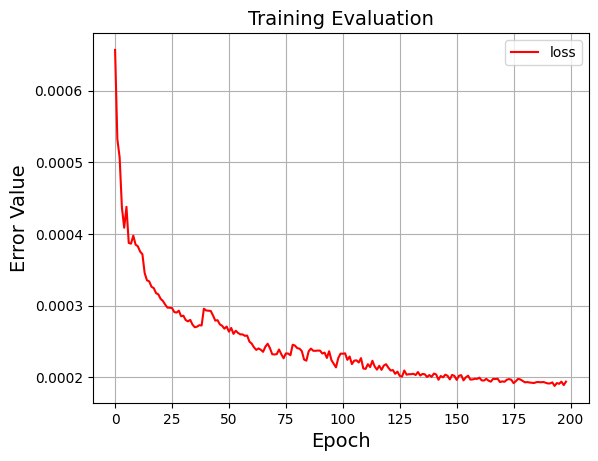

In [108]:
plt.plot(losses[1:], label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [109]:
predictions = model.forward(x_train).detach().numpy()

print("Metrics for training set:")

# if activation == nn.ReLU():
if isinstance(activation, nn.ReLU):
    train_r2 = r2_score(min_max_scaler.inverse_transform(y_train), min_max_scaler.inverse_transform(predictions))
    print("r2:", train_r2)
    print("rmse:", mean_squared_error(min_max_scaler.inverse_transform(y_train), min_max_scaler.inverse_transform(predictions), squared=False))
else:
    train_r2 = r2_score(y_train, predictions)
    print("r2111:", train_r2)
    print("rmse:", mean_squared_error(y_train, predictions, squared=False))



Metrics for training set:
r2: 0.9891940274961203
rmse: 4551.371488506595


In [110]:
predictions = model.forward(x_test).detach().numpy()

print("Metrics for testing set:")

# if activation == nn.ReLU():
if isinstance(activation, nn.ReLU):
    model_r2 = r2_score(min_max_scaler.inverse_transform(y_test), min_max_scaler.inverse_transform(predictions))
    print("r2:", model_r2)
    print("rmse:", mean_squared_error(min_max_scaler.inverse_transform(y_test), min_max_scaler.inverse_transform(predictions), squared=False))
else:
    model_r2 = r2_score(y_test, predictions)
    print("r2:", model_r2)
    print("rmse:", mean_squared_error(y_test, predictions, squared=False))

Metrics for testing set:
r2: 0.976586774569071
rmse: 6847.752567775248


Save iteration

In [111]:
dl_steps = {"learning_rate":learning_rate, "batch_size":batch_size, "epochs":epochs,"layers":model.multiple_layers, "best_r2":model_r2, "train_r2":train_r2}

ml = pd.json_normalize(dl_steps)


with open("./current_iteration_files/preprocessing.json", "r") as outfile: 
    preprocessing_steps = json.load(outfile, )

preprocessing = pd.json_normalize(preprocessing_steps)

all_process = pd.concat([preprocessing, ml], axis=1)
pd.set_option("display.max_colwidth", None)


In [112]:
try:
    iterations = pd.read_csv("./tested_iterations.csv", dtype=str)
    new_iterations = pd.concat([iterations,all_process.astype(str)], ignore_index=True, axis=0)
    if new_iterations.duplicated().sum() != 0:
        print("Current steps are duplicate of previous iteration. Current iteration will not be saved in the file.")
    else:
        new_iterations.to_csv("./tested_iterations.csv", index=False)

except:
    all_process.to_csv("./tested_iterations.csv", index=False)

<h4 style="color:yellow;">Saving the model</h4>

Every run ng code, may possibility na mag-iba yung performance kahit same yung architecture kasi iba-iba yung initial guess ng model every run.


If nakakuha kayo ng model na 90+ na yung r2 pwede niyo na isave for later use, note niyo na lang yung exact r2 niya para madecide natin kung yun kukunin as final model next week


In [113]:
filename = "./models/dlmodel_score_yourname"
# filename = "/models/neil"

state = { 'state_dict': model.state_dict() }

torch.save(state, filename)

In [ ]:
# in case you want to load the model again:
model = NeuralNetwork(in_dim, out_dim) #make sure niyo na same yung architecture ng model class sa sinave niyo na model
model.load_state_dict(torch.load(filename))
model.to(device)


print(model())